In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The code does not work with the latest JAX.

In [1]:
!pwd

/home/Prat/Documents/codes/Mass_function


In [2]:
!pip install jax
!pip install jaxns
!pip install git+https://github.com/adam-coogan/jaxinterp2d.git
!pip install corner


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.1 MB 1.3 MB/s 
     |████████████████████████████████| 124 kB 7.3 MB/s 
     |████████████████████████████████| 65 kB 7.7 MB/s 
     |████████████████████████████████| 127 kB 7.8 MB/s 
Using legacy 'setup.py install' for jax, since package 'wheel' is not installed.
    Running setup.py install for jax ... - \ | / - done
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 92 kB 574 kB/s 
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... - \ | / - \ | / - \ | / done
    Preparing wheel metadata ... - done
  Created wheel for jaxns: filename=jaxns-1.1.2-py3-none-any.whl size=112682 sha256=0bdc5731f14d2cf13cf7b5010772aff0bcf875e68ff1058447896a2fe74a0bbe
  Stored in directory: /

In [23]:
from jaxns import NestedSampler, save_results
from jaxns.prior_transforms import PriorChain, UniformPrior
from jaxns import summary, marginalise_dynamic
from jaxns import plot_cornerplot, plot_diagnostics
from jax.scipy.linalg import solve_triangular
from jax import random, jit
from jax import numpy as jnp



# import jax
# import jaxns
# from jaxns import NestedSampler, resample, summary, plot_cornerplot, plot_diagnostics
# from jaxns.prior_transforms import PriorChain, UniformPrior
# from jax import random, jit, vmap, grad
# from jax import numpy as jnp
# from jax.lax import cond

import astropy
import numpy as np

import h5py
import astropy.units as u

from astropy.cosmology import Planck15, FlatLambdaCDM, Flatw0waCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm

import matplotlib 
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')

from jax.config import config
config.update("jax_enable_x64", True)

In [4]:
from jaxinterp2d import interp2d, CartesianGrid

zMax = 100
H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0

cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Planck15.Om0)
speed_of_light = constants.c.to('km/s').value
zgrid = np.expm1(np.linspace(np.log(1), np.log(zMax+1), 1000))

rs = []
#Om0grid = jnp.linspace(0.2,0.4,50)
Om0grid = jnp.array([Om0Planck-0.01,Om0Planck,Om0Planck+0.01])
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

zgrid = jnp.array(zgrid)
rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

INFO[2022-10-19 19:45:21,008]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-10-19 19:45:21,008]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2022-10-19 19:45:21,009]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2022-10-19 19:45:21,012]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2022-10-19 19:45:21,012]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
WARNING[2022-10-19 19:45:21,013]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
100%|██████████| 3/3 [00:00<00:00, 99.43it/s]


In [9]:
def get_posdict(nEvents, nsamp=256):
    """
    load samples in GWTC-1 data release format into a dictionary
    """
    posdict = {}
    with h5py.File('observations_ce_bbh.h5', 'r') as f:#/content/drive/MyDrive/3G cosmo/
        nn, Tobs = f.attrs['1month']
        nn = int(round(nn))
        m1s = np.array(f['posteriors/m1det'])
        m2s = np.array(f['posteriors/m2det'])
        dls = np.array(f['posteriors/dl'])    
    qs = m2s/m1s 
    
    sels = np.arange(0,len(m1s))
    choose = np.random.choice(sels,nEvents,False)
    
    m1s = m1s[choose]
    m2s= m2s[choose]    
    qs = qs[choose]
    dls = dls[choose]

    sels = np.arange(0,m1s.shape[1])
    choose = np.random.choice(sels,nsamp,False)
    
    m1s = m1s[:,choose]
    m2s= m2s[:,choose]    
    qs = qs[:,choose]
    dls = dls[:,choose]
    
    posdict['m1det'] = m1s.flatten()
    posdict['m2det'] = m2s.flatten()
    posdict['q'] = qs.flatten()  
    posdict['dL'] = (dls.flatten()*u.Gpc).to(u.Mpc).value 
    posdict['nsamples'] = nsamp
    return posdict, nn, Tobs

In [10]:
nEvents = int(10376/10)
nsamp = 256
posdict, nn, Tobs = get_posdict(nEvents=nEvents,nsamp=nsamp)

m1det = jnp.array(posdict['m1det'])
m2det = jnp.array(posdict['m2det'])
dL = jnp.array(posdict['dL'])

Tobs = Tobs/5

print(z_of_dL(dL,140).max())
Tobs, nn

72.66332275914229


(0.008333333333333333, 10376)

In [11]:
with h5py.File('selected_ce_bbh.h5', 'r') as inp: #/content/drive/MyDrive/3G cosmo/
    Ndraw = inp.attrs['N_gen']

    m1detsels = np.array(inp['m1det'])
    m2detsels = np.array(inp['m2det'])
    dLsels = (np.array(inp['dl'])*u.Gpc).to(u.Mpc).value
    p_draw = np.array(inp['wt'])

print(len(m1detsels), Ndraw)

nsel = len(m1detsels)
f = float(nsel)/float(len(m1detsels))
choose = np.random.choice(m1detsels.shape[0], replace=False, size=nsel)
Ndraw = int(round(f*Ndraw))

m1detsels = jnp.array(m1detsels[choose])
m2detsels = jnp.array(m2detsels[choose])
dLsels = jnp.array(dLsels[choose])
p_draw = jnp.array(p_draw[choose])

print(len(m1detsels), Ndraw)
print(z_of_dL(dLsels,140).max())

4272810 11010048
4272810 11010048
98.90637120093652


Inference with 2 powerlaws for m1 amd m2


In [12]:
from jax.scipy.stats import norm

mass = jnp.exp(jnp.linspace(jnp.log(1), jnp.log(100), 2000))

@jit
def logpm1(m1,m_min,m_max,alpha,smooth_min=0.1):
    pm1s = mass**(-alpha)*norm.cdf(jnp.log(mass),loc=jnp.log(m_min), scale=smooth_min)*(1-norm.cdf(jnp.log(mass),loc=jnp.log(m_max), scale=smooth_min))
    cm1s = jnp.trapz(pm1s,mass)
    pm1s = pm1s/cm1s
    return jnp.log(jnp.interp(m1,mass,pm1s))

@jit
def logpm2(m2,m_min,m_max,beta,smooth_min=0.1):
    pm2s = mass**beta*norm.cdf(jnp.log(mass),loc=jnp.log(m_min), scale=smooth_min)*(1-norm.cdf(jnp.log(mass),loc=jnp.log(m_max), scale=smooth_min))
    cm2s = jnp.trapz(pm2s,mass)
    pm2s = pm2s/cm2s
    return jnp.log(jnp.interp(m2,mass,pm2s))

@jit
def psi(z,gamma,kappa,z_peak):
    psi_of_z = (1 + z) ** gamma / (1 + ((1 + z) / (1 + z_peak)) ** (gamma + kappa))
    psi_of_z *= 1 + (1 + z_peak) ** (-kappa-gamma)
    return psi_of_z

@jit
def logpz(z,gamma,kappa,z_peak):
    prob = dV_of_z(zgrid,H0Planck)*(1+zgrid)**(-1)*psi(zgrid,gamma,kappa,z_peak)
    prob = prob/jnp.trapz(prob,zgrid)
    return jnp.log(jnp.interp(z,zgrid,prob))

In [13]:
@jit
def log_p_pop(m1,m2,z,s1z,s2z,m_min=5.,m_max=45.,alpha=0.75,beta=0,gamma=1.9,kappa=3.4,z_peak=2.4):

    log_dNdm1 = logpm1(m1,m_min,m_max,alpha,smooth_min=0.1)
    log_dNdm2 = logpm2(m2,m_min,m_max,beta,smooth_min=0.1)
    log_dNdz = logpz(z,gamma,kappa,z_peak)

    log_p_sz = np.log(0.25) # 1/2 for each spin dimension

    return log_p_sz + log_dNdz + log_dNdm1 + log_dNdm2

1.0 0.9999999999999998


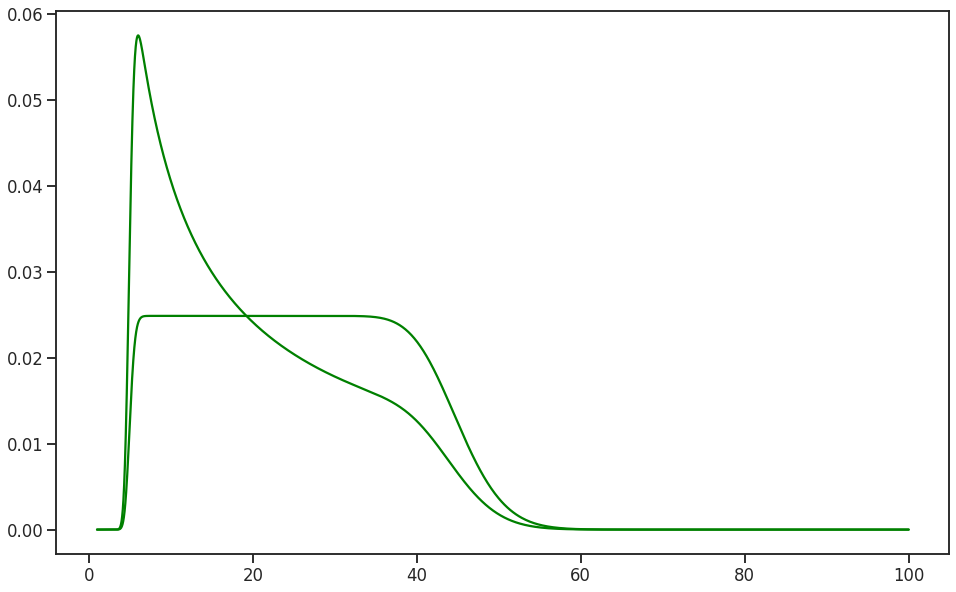

In [14]:
pm1s = jnp.exp(logpm1(mass,m_min=5.,m_max=45.,alpha=0.75))
pm2s = jnp.exp(logpm2(mass,m_min=5.,m_max=45.,beta=0))
plt.plot(mass,pm1s,color='green')
plt.plot(mass,pm2s,color='green')
print(jnp.trapz(pm1s,mass), jnp.trapz(pm2s,mass))

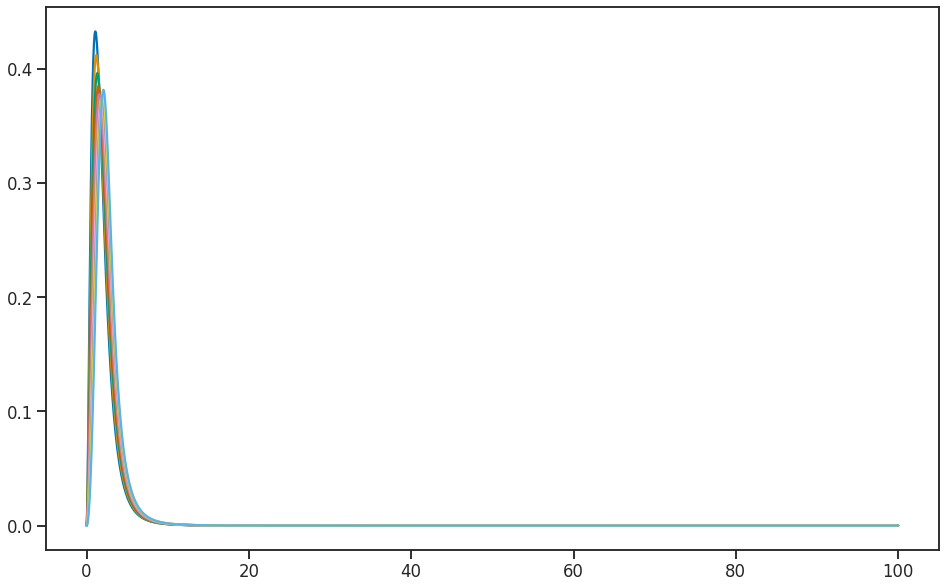

In [15]:
for gamma in jnp.linspace(0,3,10):
    plt.plot(zgrid,jnp.exp(logpz(zgrid,gamma,kappa=3.4,z_peak=2.4)))

In [16]:
@jit
def log_likelihood(H0=H0Planck,m_min=5,m_max=45,alpha=0.75,beta=0,gamma=1.9,kappa=3.4,z_peak=2.4):
    zsels = z_of_dL(dLsels, H0)
    m1sels = m1detsels/(1+zsels)
    m2sels = m2detsels/(1+zsels)

    log_det_weights = log_p_pop(m1sels,m2sels,zsels,s1z=0.,s2z=0.,
                                m_min=m_min,m_max=m_max,alpha=alpha,
                                beta=beta,gamma=gamma,kappa=kappa,z_peak=z_peak) - jnp.log(ddL_of_z(zsels,dLsels,H0)) - jnp.log(p_draw) - 2*jnp.log1p(zsels)

    Nsum = jnp.exp(logsumexp(log_det_weights))
    N2sum = jnp.exp(logsumexp(2*log_det_weights))
    mu_det = Tobs/Ndraw*Nsum

    sigma_rel2 = N2sum/(Nsum*Nsum) - 1.0/Ndraw
    neff_det = 1.0/sigma_rel2

    ll = jnp.nan
    ll = jnp.where((neff_det <= 5 * nEvents), ll, 0)
    ll += -nEvents*jnp.log(mu_det) + nEvents*(3 + nEvents)/(2*neff_det);

    z = z_of_dL(dL, H0)
    m1 = m1det/(1+z)
    m2 = m2det/(1+z)

    log_weights = log_p_pop(m1,m2,z,s1z=0.,s2z=0.,
                            m_min=m_min,m_max=m_max,alpha=alpha,
                            beta=beta,gamma=gamma,kappa=kappa,z_peak=z_peak) - jnp.log(ddL_of_z(z,dL,H0)) - 2*jnp.log1p(z)

    log_weights = log_weights.reshape((nEvents,nsamp))
    ll += jnp.sum(-jnp.log(nsamp) + logsumexp(log_weights,axis=-1))
    
    return ll
    
log_likelihood(H0=H0Planck,m_min=5,m_max=45,alpha=0.75,beta=0,gamma=1.9,kappa=3.4,z_peak=2.4)

DeviceArray(-8536.60459313, dtype=float64)

In [27]:
nlp = int(10000)

with PriorChain() as prior_chain:
    UniformPrior('H0', 20, 140)
    UniformPrior('m_min', 4, 6)
    UniformPrior('m_max', 30, 100)
    UniformPrior('alpha', -1,4)
    UniformPrior('beta', -1, 4)
    UniformPrior('gamma', -5, 5)
    UniformPrior('kappa', -5, 5)
    UniformPrior('z_peak', 1.5, 3)

ns = NestedSampler(log_likelihood, prior_chain, sampler_kwargs=dict(num_slices=1))#prior_chain.U_ndims, 
key = random.PRNGKey(42)

ns = jit(ns)

results = ns(key, num_live_points=nlp)

AssertionError: num_live_points must be a static int

In [ ]:
 # We can use the summary utility to display results
summary(results)
plot_diagnostics(results)
plot_cornerplot(results)

In [ ]:
import corner

samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=100*int(results.ESS))

labels = [r'$H_0$',r'$\gamma$',r'$\log_{10}\sigma$',r'$\mu$']

truths = [Planck15.H0.value,0,np.log10(0.05),1.4]
fig = corner.corner(samples, labels=labels, hist_kwargs={'density': True}, show_titles=True,truths=truths, truth_color=c[0])
plt.show()


In [ ]:
samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=5*int(results.ESS))
sns.distplot(samples['H0'])
plt.axvline(Planck15.H0.value)
plt.xlabel(r'$H_0$')